In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv("../../data/quarterly_data.csv", encoding = 'unicode_escape')

In [ ]:
df1 = df.replace("..", np.nan)

In [ ]:
df1

In [ ]:
# original source https://machinelearningmastery.com/iterative-imputation-for-missing-values-in-machine-learning/
# summarize the number of rows with missing values for each column
for i in range(df1.shape[1]):
    n_miss = df1.iloc[:,i].isnull().sum()
    perc = n_miss / df1.shape[0] * 100
    print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))

In [ ]:
## Categories and numerical features to different dfs

cat = df1.iloc[:,0:2]
num = df1.iloc[:,2:]
num_columns = num.columns

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=10, random_state=0)
num_imp = imp.fit_transform(num)

In [ ]:
df_num_imp = pd.DataFrame(num_imp, columns=num_columns)
df_num_imp

In [ ]:
df_num_imp.isnull().sum()

In [ ]:
df_imp = pd.concat([cat, df_num_imp],axis=1)

In [ ]:
df_imp.head()

In [ ]:
df4 = df_imp.melt(id_vars=["Postal code", "Building type"],var_name="Quarter", value_name="EUR/m2")

In [ ]:
df4.loc[df4["Postal code"] == "00100 Helsinki Keskusta - Etu-Töölö   (Helsinki )"]

In [ ]:
### Regex to change quarters to datetime
import datetime as date

def quarter_to_datetime(row):
    dates = {"Q1": "1/1", "Q2":"1/4", "Q3":"1/7", "Q4":"1/10"}
    string = row.replace("*", "").split(" ")[0]
    year, quarter = string[:4], string[4:]
    datetime_str = dates[quarter] + "/" + year
    return date.datetime.strptime(datetime_str, '%d/%m/%Y')
    
    
df4["Quarter"] = df4["Quarter"].apply(lambda row: quarter_to_datetime(row))
df4

In [ ]:
### Split postal code and place

df4[['Postal code', 'Location']] = df4['Postal code'].str.split(' ', 1, expand=True)
df4

In [ ]:
import pgeocode
import time

In [ ]:
postal_code_list = list(df4["Postal code"].unique())
nomi = pgeocode.Nominatim('fi')
location = nomi.query_postal_code(postal_code_list)

In [ ]:
location

In [ ]:
cond = location['latitude'].isna()
jalla = location.assign(cond1= cond)
jalla

In [ ]:
## Find rows which are empty
# Source https://www.kite.com/python/answers/how-to-find-rows-with-nan-values-in-a-pandas-dataframe-in-python


is_NaN = location.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = location[row_has_NaN]
rows_with_NaN

In [ ]:
###. WORK IN PROGRESS (93999 FOR KUUSAMO)
# THIS HAS TO BE ADDED MANUALLY

wanted_features_location = location[["postal_code", 
                                     "place_name", 
                                     "state_name", 
                                     "county_name", 
                                     "latitude", 
                                     "longitude"]]
wanted_features_location = wanted_features_location.rename(columns={"postal_code": "Postal code"})

In [ ]:
df_merge = pd.merge(df4, wanted_features_location, on="Postal code")

In [ ]:
df_merge

In [ ]:
#Some columns are missing their geolocation features :(

for i in range(df_merge.shape[1]):
    n_miss = df_merge.iloc[:,i].isnull().sum()
    perc = n_miss / df1.shape[0] * 100
    print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))

In [ ]:
df_merge.columns

In [ ]:
df_merge["Building type"].unique()

# Save a dataset for model testing

In [ ]:
wanted_columns = ['Postal code', 'Building type', 'Quarter', 'EUR/m2','latitude', 'longitude']
not_wanted_building_types = ['Building types total','Blocks of flats total']
df_only_houses = df_merge[~df_merge["Building type"].isin(not_wanted_building_types)].reset_index(drop=True)
df_only_houses["EUR/m2"] = df_only_houses["EUR/m2"].astype(int)

In [ ]:
df_only_houses["Building type"].unique()

In [ ]:
### Rename building types


def rename_building(row):
    dic = {'Blocks of flats, one-room flat':'one-room','Blocks of flats, two-room flat':'two-room',
           'Blocks of flats, three-room flat+':'three or more room', 'Terraced houses total':'terrace house'}
    return dic[row]

df_only_houses2 = df_only_houses
df_only_houses2["Building type"] = df_only_houses2["Building type"].apply(lambda r: rename_building(r))

In [ ]:
data = df_only_houses2[wanted_columns]

In [ ]:
data.head()

In [ ]:
data.to_csv("df_geo_imp.csv")

## Value of square meter of cities Q2 2021

In [ ]:
Q2_2021__one_room = df_merge[(df_merge["Quarter"] == "2021-01-04") & (df_merge["Building type"] == "Blocks of flats, one-room flat")]


In [ ]:
Q2_2021__one_room

In [ ]:
Q2_2021__one_room.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, figsize=(7,10),
 c="EUR/m2", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()
plt.title("Q2 2021 Blocks of flats, one-room flat")

### Only Helsinki

In [ ]:
helsinki_df = Q2_2021__one_room[Q2_2021__one_room["county_name"] == "Helsinki"]

helsinki_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, figsize=(7,10),
 c="EUR/m2", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.title("Helsinki")
plt.legend()

## Whole uusimaa

In [ ]:
uusimaa_df = Q2_2021__one_room[Q2_2021__one_room["state_name"] == "Uusimaa"]

uusimaa_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, figsize=(7,10),
 c="EUR/m2", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.title("Uusimaa")
plt.legend()

In [ ]:
uusimaa_df.describe()

In [ ]:
helsinki_df.sort_values(by="EUR/m2", ascending=False).head()

## Model prototype (just for testing web app)

It is worth noticing that this model has been built with imputed data. 
Therefore, model's evaluation can be wrong since the imputed data has been used for that step. 

In [ ]:
import joblib


data.head()
data2 = data.drop("Postal code", axis=1)
data2["Quarter"] = data2["Quarter"].astype(str)

In [ ]:
data2.isna().sum()

In [ ]:
data3 = data2.dropna().reset_index()

In [ ]:
# Building type and Quarter to one hot encoding
from sklearn.preprocessing import OneHotEncoder

num = data3[["longitude", "latitude", "EUR/m2"]]
cat = data3[["Building type", "Quarter"]]

In [ ]:
cat

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(cat)
oh_cat = enc.transform(cat).toarray()

In [ ]:
oh_cat_features = enc.get_feature_names(["Building type", "Quarter"])
cat_df = pd.DataFrame(oh_cat, columns=oh_cat_features)

In [ ]:
# Save encoder for streamlit
joblib.dump(enc, "onehot_encoder.pkl", compress=1)

In [ ]:
data4 = pd.concat([cat_df,num],axis=1)
data4

In [ ]:
cat_test = np.array(["one-room", "2021-01-04"])
tuloe = enc.transform(cat_test.reshape(1,-1)).toarray()
print(tuloe)

In [ ]:
## Test and train sets

train = data4[data4["Quarter_2021-01-04"] == 0.0]
test = data4[data4["Quarter_2021-01-04"] == 1.0]

In [ ]:
X_feat = list(data4.columns)
X_feat.remove('EUR/m2')

X_train, X_test = train[X_feat], test[X_feat]
y_train, y_test = train['EUR/m2'], test['EUR/m2']


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


regr = RandomForestRegressor(n_estimators=10, random_state=7)
regr.fit(X_train, y_train)

pred = regr.predict(X_test)
mean_absolute_error(y_test, pred)

In [ ]:
joblib.dump(regr,'housing_regr.pkl',compress=1)

# Time series forecasting

In [7]:
import pandas as pd

df = pd.read_csv("../Bruce/no_nans.csv")
df

,time,00100,00260,00360,00500,00520,00730,00820,01280,01300,...,33200,33560,33580,33710,33820,33850,33960,36200,37120,40520
0,2010Q1 Price per square meter (EUR/m2),5168.0,4873.0,2756.0,4058.0,3317.0,3006.0,2652.0,2098.0,2616.0,...,2827.0,1951.0,2152.0,1760.0,1859.0,1227.0,1897.0,1747.0,1613.0,1968.0
1,2010Q2 Price per square meter (EUR/m2),5219.0,5086.0,3051.0,4111.0,3706.0,3070.0,2561.0,2045.0,2688.0,...,3094.0,1816.0,2039.0,1803.0,1970.0,1254.0,2026.0,1659.0,1542.0,2110.0
2,2010Q3 Price per square meter (EUR/m2),5181.0,4939.0,2889.0,4247.0,3672.0,2944.0,2632.0,2210.0,2814.0,...,3001.0,2081.0,1978.0,1851.0,1916.0,1338.0,1700.0,1851.0,1582.0,2096.0
3,2010Q4 Price per square meter (EUR/m2),5269.0,4906.0,3037.0,4226.0,3681.0,3046.0,2580.0,2359.0,2727.0,...,2990.0,1963.0,2102.0,1740.0,1980.0,1287.0,1881.0,1715.0,1745.0,2180.0
4,2011Q1 Price per square meter (EUR/m2),5632.0,5272.0,3188.0,4342.0,3654.0,3061.0,2793.0,2165.0,2734.0,...,3122.0,2142.0,2181.0,1838.0,1851.0,1398.0,1847.0,1836.0,1660.0,2116.0
5,2011Q2 Price per square meter (EUR/m2),5807.0,5538.0,3070.0,4281.0,3864.0,2840.0,2717.0,2227.0,2869.0,...,3107.0,2125.0,2228.0,1953.0,1780.0,1257.0,1926.0,1561.0,1627.0,2213.0
6,2011Q3 Price per square meter (EUR/m2),5630.0,5166.0,2923.0,4420.0,4285.0,3189.0,2723.0,2123.0,2846.0,...,3127.0,2219.0,2179.0,1775.0,1814.0,1313.0,1783.0,1884.0,1711.0,2004.0
7,2011Q4 Price per square meter (EUR/m2),5511.0,5262.0,3052.0,4459.0,3898.0,2969.0,2663.0,2454.0,2667.0,...,2890.0,2198.0,2039.0,1709.0,1749.0,1338.0,2043.0,1709.0,1577.0,2032.0
8,2012Q1 Price per square meter (EUR/m2),5843.0,5122.0,3020.0,4429.0,3854.0,3147.0,2765.0,2358.0,3020.0,...,2756.0,2174.0,2135.0,1800.0,1586.0,1316.0,2189.0,1822.0,1725.0,2127.0
9,2012Q2 Price per square meter (EUR/m2),5899.0,5353.0,3184.0,4533.0,4057.0,3054.0,2844.0,2161.0,2933.0,...,3065.0,2070.0,2281.0,1904.0,1876.0,1328.0,1991.0,2152.0,1703.0,2257.0


In [8]:
### Regex to change quarters to datetime
import datetime as date

def quarter_to_datetime(row):
    dates = {"Q1": "1/1", "Q2":"1/4", "Q3":"1/7", "Q4":"1/10"}
    string = row.replace("*", "").split(" ")[0]
    year, quarter = string[:4], string[4:]
    datetime_str = dates[quarter] + "/" + year
    return date.datetime.strptime(datetime_str, '%d/%m/%Y')

In [9]:
df["time"] = df["time"].apply(lambda row: quarter_to_datetime(row))
postal_codes = list(df.columns)[1:]

In [10]:
df.head()

,time,00100,00260,00360,00500,00520,00730,00820,01280,01300,...,33200,33560,33580,33710,33820,33850,33960,36200,37120,40520
0,2010-01-01,5168.0,4873.0,2756.0,4058.0,3317.0,3006.0,2652.0,2098.0,2616.0,...,2827.0,1951.0,2152.0,1760.0,1859.0,1227.0,1897.0,1747.0,1613.0,1968.0
1,2010-04-01,5219.0,5086.0,3051.0,4111.0,3706.0,3070.0,2561.0,2045.0,2688.0,...,3094.0,1816.0,2039.0,1803.0,1970.0,1254.0,2026.0,1659.0,1542.0,2110.0
2,2010-07-01,5181.0,4939.0,2889.0,4247.0,3672.0,2944.0,2632.0,2210.0,2814.0,...,3001.0,2081.0,1978.0,1851.0,1916.0,1338.0,1700.0,1851.0,1582.0,2096.0
3,2010-10-01,5269.0,4906.0,3037.0,4226.0,3681.0,3046.0,2580.0,2359.0,2727.0,...,2990.0,1963.0,2102.0,1740.0,1980.0,1287.0,1881.0,1715.0,1745.0,2180.0
4,2011-01-01,5632.0,5272.0,3188.0,4342.0,3654.0,3061.0,2793.0,2165.0,2734.0,...,3122.0,2142.0,2181.0,1838.0,1851.0,1398.0,1847.0,1836.0,1660.0,2116.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 38 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    46 non-null     datetime64[ns]
 1   00100   46 non-null     float64       
 2   00260   46 non-null     float64       
 3   00360   46 non-null     float64       
 4   00500   46 non-null     float64       
 5   00520   46 non-null     float64       
 6   00730   46 non-null     float64       
 7   00820   46 non-null     float64       
 8   01280   46 non-null     float64       
 9   01300   46 non-null     float64       
 10  01450   46 non-null     float64       
 11  02200   46 non-null     float64       
 12  02210   46 non-null     float64       
 13  02320   46 non-null     float64       
 14  02400   46 non-null     float64       
 15  02760   46 non-null     float64       
 16  03100   46 non-null     float64       
 17  04410   46 non-null     float64       
 18  06100   46 n

In [12]:
# Just testing with 00100

df_00100 = df[["00100", "time"]]
df_00100 = df_00100.rename(columns={"00100":"y","time":"ds"})
df_00100.tail()

,y,ds
41,7275.0,2020-04-01
42,8058.0,2020-07-01
43,7540.0,2020-10-01
44,8188.0,2021-01-01
45,8188.0,2021-04-01


NameError: name 'plt' is not defined

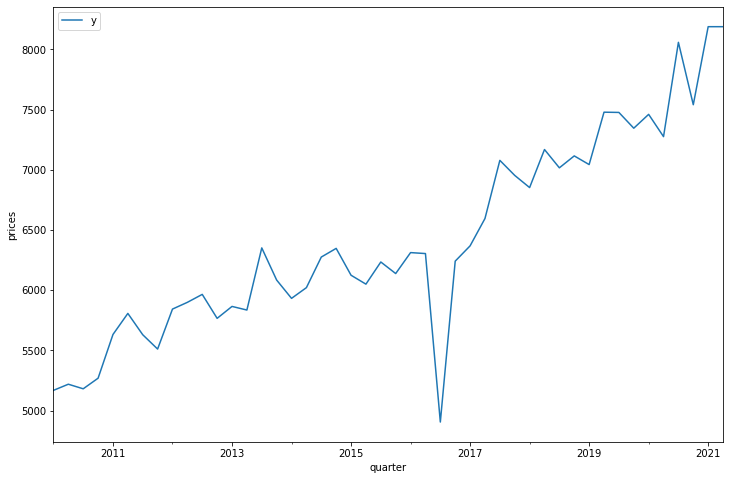

In [13]:

ax = df_00100.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel("prices")
ax.set_xlabel('quarter')

plt.show()

In [ ]:
df_00100["ds"]

In [14]:
# Setting up the model
prop = Prophet(interval_width=0.95)

NameError: name 'Prophet' is not defined

In [ ]:
train, test = df_00100[:-4], df_00100[-4:]

In [ ]:
prop.fit(train)

In [ ]:
def make_dates_from_string(string):
    return date.datetime.strptime(string, '%d/%m/%Y')

old_dates = prop.make_future_dataframe(periods=0)
"""future_dates = ["1/7/2021", "1/10/2021", 
                "1/1/2022", "1/4/2022", "1/7/2022", "1/10/2022", 
                "1/1/2023", "1/4/2023", "1/7/2023", "1/10/2023",
                "1/1/2024", "1/4/2024"]"""
future_dates = ["1/7/2020", "1/10/2020", "1/1/2021", "1/4/2021"]
dates = [make_dates_from_string(d) for d in future_dates]
future_df = pd.DataFrame({"ds": dates})
future_dates_df = pd.concat([old_dates,future_df]).reset_index(drop=True)

In [ ]:
future_df

In [ ]:
forecast = prop.predict(future_dates_df)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

In [ ]:
prop.plot(forecast, uncertainty=True)

In [ ]:
prop.plot_components(forecast)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

ax = forecast.plot(x='ds',y='yhat',legend=True,label='PRED',figsize=(12,8))
test.plot(x='ds',y='y',legend=True,label='TRUE', ax=ax, xlim=("2020-07-01", "2021-04-01"))
print("RMSE")
print(math.sqrt(mean_squared_error(test["y"], list(forecast["yhat"][-4:]))))

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

y_true = df_00100['y'].values
y_pred = forecast['yhat'][:46].values
mae = mean_absolute_error(y_true, y_pred)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))

print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)

# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

#### MAE and RMSE for each postal code (predict last four quarters)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def prophet_for_each_postalcodes(df, postal_codes, time="time"):

    mae_values = []
    rmse_values = []

    for pc in postal_codes:
        print(pc)
        pc_df = df[[pc, time]].rename(columns={pc:"y",time:"ds"})
        train, test = pc_df[:-4], pc_df[-4:]
        print(train)
        print(test)
        prop = Prophet(interval_width=0.95)
        prop.fit(train)
        forecast = prop.predict(test)
        mae = mean_absolute_error(test["y"], forecast["yhat"])
        rmse = math.sqrt(mean_squared_error(test["y"], forecast["yhat"]))
        mae_values.append(mae)
        rmse_values.append(rmse)

    data = pd.DataFrame({"postal code":postal_codes, "rmse":rmse_values, "mae":mae_values })
    return data, mae_values, rmse_values

data, mae_values, rmse_values = prophet_for_each_postalcodes(df, postal_codes)

In [126]:
import statistics

def show_results(data, mae_values, rmse_values,postal_code="postal code"):
    avg_rmse = statistics.mean(rmse_values)
    avg_mae = statistics.mean(mae_values)
    data.plot.bar(x=postal_code, subplots=True, figsize=(15,10))
    print('Average MAE: %.3f' % avg_mae)
    print('Average RMSE: %.3f' % avg_rmse)
    data.describe()

Average MAE: 1650.188
Average RMSE: 1650.188


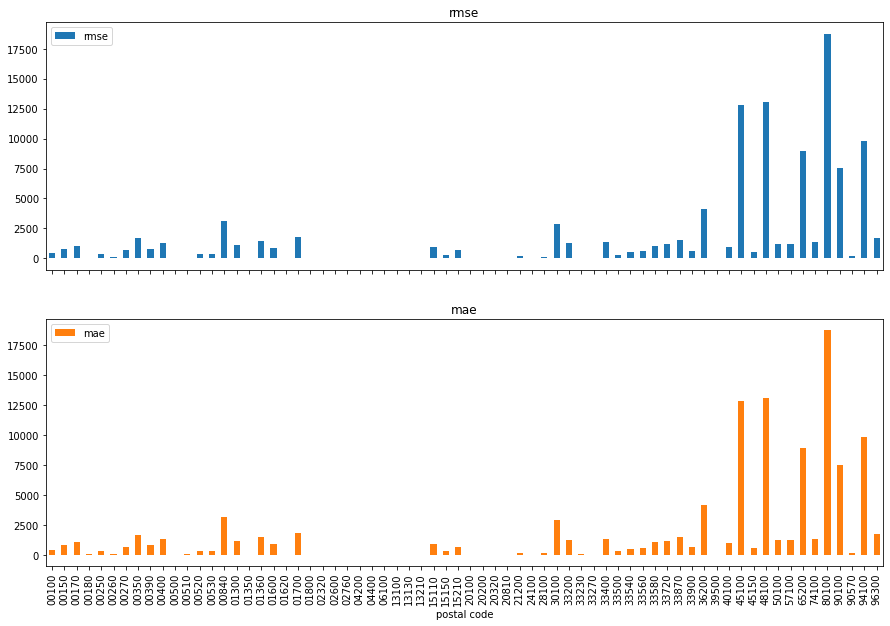

In [127]:
show_results(data,mae_values, rmse_values)

### With TAE's clustering methods

In [ ]:
# Lets test with "Blocks of flats, one-room flat"

building_type = "Blocks of flats, one-room flat"

c_data = pd.read_csv("cluster-Copy1.csv", dtype={"Postal code": str})
c_data = c_data[c_data["Building type"].isin([building_type])]
data_labels = c_data[["Postal code","label2", "label4", "label5", "label7", "label8", "label10", "longitude", "latitude"]]

#### Disclaimer, clustered data is from imputed data. Therefore, it is not 100% accurate when predicting clusters. 

In [ ]:
data_labels.head()

In [ ]:
## Lets combine with Bruces data

new_df = df.T
columns = new_df.iloc[0]
new_df = new_df.drop("time")
new_df.columns = columns
new_df[columns] = new_df[columns].apply(pd.to_numeric)
new_df = new_df.reset_index()
new_df = new_df.rename(columns={"index":"Postal code"})
new_df

In [ ]:
new_df = new_df.merge(data_labels, on="Postal code", how="left")
new_df = new_df.dropna()
new_df.head()

In [ ]:
# Split data into different categories by labels.
# 1. Select label
# 2. Find postal codes belonging that label
# 3. Take mean value from all prices belonging that label
# 4. Return table containing mean housing price for each label

def select_labels(data, label):
    labels = list(data[label].unique())
    new_data = data.groupby(by=[label]).mean()
    new_data = new_data.T[:-7].reset_index()
    new_data = new_data.rename(columns={"index":"ds"})
    return new_data, labels
    

label = "label2"
clustered_df, labels = select_labels(new_df, label)

In [ ]:
results, mae_values, rmse_values = prophet_for_each_postalcodes(clustered_df, labels, time="ds")

In [ ]:
all_labels = ["label2", "label5", "label7", "label8", "label10"]
all_result = []
all_mae = []
all_rmse = []

# Fitting for different labels

for label in all_labels:
    clustered_df, labels = select_labels(new_df, label)
    results2, mae_values2, rmse_values2 = prophet_for_each_postalcodes(clustered_df, labels, time="ds")
    all_result.append(results2)
    all_mae.append(mae_values2)
    all_rmse.append(rmse_values2)

In [ ]:
print(len(all_rmse))

for i in range(len(all_result)):
    print("When using {}:".format(all_labels[i]))
    show_results(all_result[i], all_mae[i], all_rmse[i])